
# Pure Substance Properties using Canteras and Coolprops built-in EOSs, as well as the Burke Mechanism

This is a comparison between several equations of state using Cantera and CoolProp. \
The fluids considered are H2, O2, N2, CH4 (Reactants), as well as H2O and CO2 (Products). \
The following EOS are used:

1. The ideal gas EOSs in Canteras gri30 and gri30_ion Mechanisms, and the Burke Mechanism
2. The Redlich-Kwong EOS from Canteras h2o2.yaml (does not have CO2, CH4!)
3. The Purefluid EOSs from Cantera (Diverse sources)
4. The Helmholtz energy EOS (HEOS) from CoolProp
5. The Suave-Redlich-Kwong & Peng-Robinson EOSs from Coolprop

Code Structure: https://cantera.org/stable/examples/python/thermo/equations_of_state.html \
Canteras Purefluid Objects: https://cantera.org/stable/python/importing.html#pure-fluid-phases \
High Level CoolProp Cubics usage: http://www.coolprop.org/coolprop/Cubics.html#cubic-backend \
Coolprop Low Level Interface: http://www.coolprop.org/coolprop/LowLevelAPI.html \
Burke Mechanism: https://burke.me.columbia.edu/content/mechanisms-and-downloads

In [36]:
#Imports
import cantera as ct
import numpy as np
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI #High Level CoolProp interface
import matplotlib.pyplot as plt
import pandas as pd #Needed to read NIST Data

# Backend Setup, Calculating values

First we set up the backend functions for property calculations, identically to the Non-Ideal EOS Cantera database example. \
As is noted there, since Enthalpy/Entropy are relative values and the standard-reference thermodynamic states for Cantera and Coolprop are different, it is necessary to zero them out before comparison.

The following functions are set up to expect an array of pressures, but constant Temperatures:

In [37]:
def get_thermo_Cantera_Mech(phase, T, p, X):
    states = ct.SolutionArray(phase, len(p)) #Same Sizee as p Array
    states.TPX = T, p, X

    u = states.u / 1000
    h = states.h / 1000
    s = states.s / 1000
    cp = states.cp / 1000
    cv = states.cv / 1000
    rho = states.density

    # Get the relative enthalpy, entropy and int. energy with reference to the first point
    u = u - u[0]
    s = s - s[0]
    h = h - h[0]

    return h, u, s, cp, cv, rho

def get_thermo_Cantera_PureFluid(T, p_array, Fluid): #PureFluids expect scalar values
    u, h, s, cp, cv, rho = [], [], [], [], [], [] #We need to set up lists
    for p in p_array: #And then loop through them
        Fluid.TP = T, p
        u.append(Fluid.u / 1000)
        h.append(Fluid.h / 1000)
        s.append(Fluid.s / 1000)
        cp.append(Fluid.cp / 1000)
        cv.append(Fluid.cv / 1000)
        rho.append(Fluid.density)
    
    #Convert the lists to arrays
    u = np.array(u)
    h = np.array(h)
    s = np.array(s)
    cp = np.array(cp)
    cv = np.array(cv)
    rho = np.array(rho)
    
    # Get the relative enthalpy, entropy and int. energy with reference to the first point (can only be done with arrays)
    u = u - u[0]
    s = s - s[0]
    h = h - h[0]

    return h, u, s, cp, cv, rho

def get_thermo_CoolProp(T, p, EOSX):
    u = np.zeros_like(p)
    h = np.zeros_like(p)
    s = np.zeros_like(p)
    cp = np.zeros_like(p)
    cv = np.zeros_like(p)
    rho = np.zeros_like(p)

    for i in range(p.shape[0]):
        u[i] = PropsSI("U", "P", p[i], "T", T, EOSX)
        h[i] = PropsSI("H", "P", p[i], "T", T, EOSX)
        s[i] = PropsSI("S", "P", p[i], "T", T, EOSX)
        cp[i] = PropsSI("C", "P", p[i], "T", T, EOSX)
        cv[i] = PropsSI("O", "P", p[i], "T", T, EOSX)
        rho[i] = PropsSI("D", "P", p[i], "T", T, EOSX)

    # Get the relative enthalpy, entropy and int. energy with reference to the first
    # point
    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

We also need functions where T is varied, p is constant. This is achieved by modifying the above slightly:

In [38]:
def get_thermo_Cantera_Mech_Tvar(phase, T, p, X):
    states = ct.SolutionArray(phase, len(T)) #Now, same Size as T Array
    states.TPX = T, p, X

    u = states.u / 1000
    h = states.h / 1000
    s = states.s / 1000
    cp = states.cp / 1000
    cv = states.cv / 1000
    rho = states.density

    u = u - u[0]
    s = s - s[0]
    h = h - h[0]

    return h, u, s, cp, cv, rho

def get_thermo_Cantera_PureFluid_Tvar(T_array, p, Fluid): #Scalar values needed, just as above
    u, h, s, cp, cv, rho = [], [], [], [], [], [] 
    for T in T_array: #This time loops through Temperatures
        Fluid.TP = T, p
        u.append(Fluid.u / 1000)
        h.append(Fluid.h / 1000)
        s.append(Fluid.s / 1000)
        cp.append(Fluid.cp / 1000)
        cv.append(Fluid.cv / 1000)
        rho.append(Fluid.density)

    u = np.array(u)
    h = np.array(h)
    s = np.array(s)
    cp = np.array(cp)
    cv = np.array(cv)
    rho = np.array(rho)

    u = u - u[0]
    s = s - s[0]
    h = h - h[0]

    return h, u, s, cp, cv, rho

def get_thermo_CoolProp_Tvar(T, p, EOSX):
    u = np.zeros_like(T)
    h = np.zeros_like(T)
    s = np.zeros_like(T)
    cp = np.zeros_like(T)
    cv = np.zeros_like(T)
    rho = np.zeros_like(T)

    for i in range(T.shape[0]):
        u[i] = PropsSI("U", "P", p, "T", T[i], EOSX)
        h[i] = PropsSI("H", "P", p, "T", T[i], EOSX)
        s[i] = PropsSI("S", "P", p, "T", T[i], EOSX)
        cp[i] = PropsSI("C", "P", p, "T", T[i], EOSX)
        cv[i] = PropsSI("O", "P", p, "T", T[i], EOSX)
        rho[i] = PropsSI("D", "P", p, "T", T[i], EOSX)

    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

CoolProps Cubic EOSs present an additional challenge: \
For Case 1, the CPs PR EOSs is unstable near the phase Transition region. \
For Case 2, due to our chosen pressure level (100atm), both the SRK and PR Backends start throwing errors at low as well as high Temperatures. \
The remedy to this is either providing a density guess (working with rhoT instead of pT), or specifying the phase of the Fluid. \
We will go with the former, and write our backend functions to use density guesses like this:

In [40]:
#Case 1 SRK with rhoGuess
def get_thermo_CoolProp_SRK_rhoGuess(T, p, X, G):
    AS = CP.AbstractState("SRK", X)
    u = np.zeros_like(p)
    h = np.zeros_like(p)
    s = np.zeros_like(p)
    cp = np.zeros_like(p)
    cv = np.zeros_like(p)
    rho = np.zeros_like(p)
    for i in range(p.shape[0]):
        if T[i] < PropsSI(X, "T_min"):
            ideal_gas1.TPX = T, p[i], G 
            rho_guess = ideal_gas1.density
        elif T[i] > PropsSI(X, "T_min"):
            ideal_gas1.TPX = T, p[i], G #If Temperature is outside of HEOS Range, then provide ideal gas density as guess
            rho_guess = ideal_gas1.density
        else:
            rho_guess = PropsSI("D", "P", p[i], "T", T, X) #Else T is in range, so provide HEOS Density
        AS.update(CP.DmassT_INPUTS, rho_guess, T)
        u[i] = AS.umass()
        h[i] = AS.hmass()
        s[i] = AS.smass()
        cp[i] = AS.cpmass()
        cv[i] = AS.cvmass()
        rho[i] = AS.rhomass()

    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

#Case 2 SRK with rhoGuess
def get_thermo_CoolProp_SRK_rhoGuess_Tvar(T, p, X, G):
    AS = CP.AbstractState("SRK", X)
    u = np.zeros_like(T)
    h = np.zeros_like(T)
    s = np.zeros_like(T)
    cp = np.zeros_like(T)
    cv = np.zeros_like(T)
    rho = np.zeros_like(T)
    for i in range(T.shape[0]): #Works only with Case 2, since T is assumed to be an array
        if T[i] < PropsSI(X, "T_min"):
            ideal_gas1.TPX = T[i], p, G 
            rho_guess = ideal_gas1.density
        elif T[i] > PropsSI(X, "T_min"):
            ideal_gas1.TPX = T[i], p, G #If Temperature is outside of HEOS Range, then provide ideal gas density as guess
            rho_guess = ideal_gas1.density
        else:
            rho_guess = PropsSI("D", "P", p, "T", T[i], X) #Else T is in range, so provide HEOS Density
        AS.update(CP.DmassT_INPUTS, rho_guess, T[i])
        u[i] = AS.umass()
        h[i] = AS.hmass()
        s[i] = AS.smass()
        cp[i] = AS.cpmass()
        cv[i] = AS.cvmass()
        rho[i] = AS.rhomass()

    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

#Case 1 PR with rhoGuess
def get_thermo_CoolProp_PR_rhoGuess(T, p, X):
    AS = CP.AbstractState("PR", X)
    u = np.zeros_like(p)
    h = np.zeros_like(p)
    s = np.zeros_like(p)
    cp = np.zeros_like(p)
    cv = np.zeros_like(p)
    rho = np.zeros_like(p)
    for i in range(p.shape[0]):
        rho_guess = PropsSI("D", "P", p[i], "T", T, X)
        AS.update(CP.DmassT_INPUTS, rho_guess, T)
        u[i] = AS.umass()
        h[i] = AS.hmass()
        s[i] = AS.smass()
        cp[i] = AS.cpmass()
        cv[i] = AS.cvmass()
        rho[i] = AS.rhomass()
    # Get the relative enthalpy, entropy and int. energy with reference to the first
    # point
    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

#Case 2 PR with rhoGuess
def get_thermo_CoolProp_PR_rhoGuess_Tvar(T, p, X, G):
    AS = CP.AbstractState("PR", X)
    u = np.zeros_like(T)
    h = np.zeros_like(T)
    s = np.zeros_like(T)
    cp = np.zeros_like(T)
    cv = np.zeros_like(T)
    rho = np.zeros_like(T)
    for i in range(T.shape[0]):
        #If Temperature is outside of HEOS Range, then provide ideal gas density as guess
        if T[i] < PropsSI(X, "T_min"):
            ideal_gas1.TPX = T[i], p, G
            rho_guess = ideal_gas1.density
        elif T[i] > PropsSI(X, "T_min"):
            ideal_gas1.TPX = T[i], p, G
            rho_guess = ideal_gas1.density
        #Else T is in range, so provide HEOS Density
        else:
            rho_guess = PropsSI("D", "P", p, "T", T[i], X)
        AS.update(CP.DmassT_INPUTS, rho_guess, T[i])
        u[i] = AS.umass()
        h[i] = AS.hmass()
        s[i] = AS.smass()
        cp[i] = AS.cpmass()
        cv[i] = AS.cvmass()
        rho[i] = AS.rhomass()
    # Get the relative enthalpy, entropy and int. energy with reference to the first
    # point
    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

In [5]:
# Our Input parameters for Case 1 (Constant T, variable p) and Case 2 (Variable T, constant p)
T_1 = 300
p_1 = 101325 * np.linspace(1, 300, 300)  # Pressure is varied from 1 to 300 atm [Pa]
T_2 = 10 * np.linspace(2, 200, 199)  # Temperature is varied from 20 to 2000 K
p_2 = 101325 * 100 # 100 atm [Pa]

Now we read in all the phases used. \
Note that for Canteras Solution objects, we only need to specify a thermo for h2o2.yaml, as all the others used contain only one phase (ideal gas only) \
For Pure Fluids, we need to use the correct strings ("CarbonDioxide" for CO2, "Hydrogen" for H2 etc.)

In [6]:
# Read the ideal-gas phase Objects
ideal_gas1 = ct.Solution('gri30.yaml')
ideal_gas2 = ct.Solution('gri30_ion.yaml')
ideal_gas3 = ct.Solution('Law Replication/Burke Mech/Burke_chem_cti.yaml')
ideal_gas4 = ct.Solution('h2o2.yaml',thermo='ideal-gas') #needs to be specified

# Read Canteras Redlich-Kwong phase, No data for CO2/CH4 is available in h2o2.yaml!
redlich_kwong = ct.Solution('h2o2.yaml',thermo='R-K')

In [7]:
# Read each ideal-gas Phase for Carbon Dioxide, not present in h2o2!
h_ideal_CO2_GRI, u_ideal_CO2_GRI, s_ideal_CO2_GRI, cp_ideal_CO2_GRI, cv_ideal_CO2_GRI, rho_ideal_CO2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T_1, p_1, "CO2:1.0")
h_ideal_CO2_GRION, u_ideal_CO2_GRION, s_ideal_CO2_GRION, cp_ideal_CO2_GRION, cv_ideal_CO2_GRION, rho_ideal_CO2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T_1, p_1, "CO2:1.0")
h_ideal_CO2_Burke, u_ideal_CO2_Burke, s_ideal_CO2_Burke, cp_ideal_CO2_Burke, cv_ideal_CO2_Burke, rho_ideal_CO2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T_1, p_1, "CO2:1.0")

# Read each ideal-gas Phase for Hydrogen
h_ideal_H2_GRI, u_ideal_H2_GRI, s_ideal_H2_GRI, cp_ideal_H2_GRI, cv_ideal_H2_GRI, rho_ideal_H2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T_1, p_1, "H2:1.0")
h_ideal_H2_GRION, u_ideal_H2_GRION, s_ideal_H2_GRION, cp_ideal_H2_GRION, cv_ideal_H2_GRION, rho_ideal_H2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T_1, p_1, "H2:1.0")
h_ideal_H2_Burke, u_ideal_H2_Burke, s_ideal_H2_Burke, cp_ideal_H2_Burke, cv_ideal_H2_Burke, rho_ideal_H2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T_1, p_1, "H2:1.0")
h_ideal_H2_h2o2, u_ideal_H2_h2o2, s_ideal_H2_h2o2, cp_ideal_H2_h2o2, cv_ideal_H2_h2o2, rho_ideal_H2_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T_1, p_1, "H2:1.0")

# Read each ideal-gas Phase for Methane, not present in Burke & h2o2!
h_ideal_CH4_GRI, u_ideal_CH4_GRI, s_ideal_CH4_GRI, cp_ideal_CH4_GRI, cv_ideal_CH4_GRI, rho_ideal_CH4_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T_1, p_1, "CH4:1.0")
h_ideal_CH4_GRION, u_ideal_CH4_GRION, s_ideal_CH4_GRION, cp_ideal_CH4_GRION, cv_ideal_CH4_GRION, rho_ideal_CH4_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T_1, p_1, "CH4:1.0")

# Read each ideal-gas Phase for Nitrogen
h_ideal_N2_GRI, u_ideal_N2_GRI, s_ideal_N2_GRI, cp_ideal_N2_GRI, cv_ideal_N2_GRI, rho_ideal_N2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T_1, p_1, "N2:1.0")
h_ideal_N2_GRION, u_ideal_N2_GRION, s_ideal_N2_GRION, cp_ideal_N2_GRION, cv_ideal_N2_GRION, rho_ideal_N2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T_1, p_1, "N2:1.0")
h_ideal_N2_Burke, u_ideal_N2_Burke, s_ideal_N2_Burke, cp_ideal_N2_Burke, cv_ideal_N2_Burke, rho_ideal_N2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T_1, p_1, "N2:1.0")
h_ideal_N2_N2o2, u_ideal_N2_h2o2, s_ideal_N2_h2o2, cp_ideal_N2_h2o2, cv_ideal_N2_h2o2, rho_ideal_N2_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T_1, p_1, "N2:1.0")

# Read each ideal-gas Phase for Oxygen
h_ideal_O2_GRI, u_ideal_O2_GRI, s_ideal_O2_GRI, cp_ideal_O2_GRI, cv_ideal_O2_GRI, rho_ideal_O2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T_1, p_1, "O2:1.0")
h_ideal_O2_GRION, u_ideal_O2_GRION, s_ideal_O2_GRION, cp_ideal_O2_GRION, cv_ideal_O2_GRION, rho_ideal_O2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T_1, p_1, "O2:1.0")
h_ideal_O2_Burke, u_ideal_O2_Burke, s_ideal_O2_Burke, cp_ideal_O2_Burke, cv_ideal_O2_Burke, rho_ideal_O2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T_1, p_1, "O2:1.0")
h_ideal_O2_O2o2, u_ideal_O2_h2o2, s_ideal_O2_h2o2, cp_ideal_O2_h2o2, cv_ideal_O2_h2o2, rho_ideal_O2_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T_1, p_1, "O2:1.0")

# Read each ideal-gas Phase for Water
h_ideal_H2O_GRI, u_ideal_H2O_GRI, s_ideal_H2O_GRI, cp_ideal_H2O_GRI, cv_ideal_H2O_GRI, rho_ideal_H2O_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T_1, p_1, "H2O:1.0")
h_ideal_H2O_GRION, u_ideal_H2O_GRION, s_ideal_H2O_GRION, cp_ideal_H2O_GRION, cv_ideal_H2O_GRION, rho_ideal_H2O_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T_1, p_1, "H2O:1.0")
h_ideal_H2O_Burke, u_ideal_H2O_Burke, s_ideal_H2O_Burke, cp_ideal_H2O_Burke, cv_ideal_H2O_Burke, rho_ideal_H2O_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T_1, p_1, "H2O:1.0")
h_ideal_H2O_H2OH2O, u_ideal_H2O_h2o2, s_ideal_H2O_h2o2, cp_ideal_H2O_h2o2, cv_ideal_H2O_h2o2, rho_ideal_H2O_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T_1, p_1, "H2O:1.0")

In [18]:
# Do the same for Case 2 (variable T). It uses *_Tvar for all variables/function names to differentiate between the two Cases:
# CO2
h_ideal_CO2_GRI_Tvar, u_ideal_CO2_GRI_Tvar, s_ideal_CO2_GRI_Tvar, cp_ideal_CO2_GRI_Tvar, cv_ideal_CO2_GRI_Tvar, rho_ideal_CO2_GRI_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas1, T_2, p_2, "CO2:1.0")
h_ideal_CO2_GRION_Tvar, u_ideal_CO2_GRION_Tvar, s_ideal_CO2_GRION_Tvar, cp_ideal_CO2_GRION_Tvar, cv_ideal_CO2_GRION_Tvar, rho_ideal_CO2_GRION_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas2, T_2, p_2, "CO2:1.0")
h_ideal_CO2_Burke_Tvar, u_ideal_CO2_Burke_Tvar, s_ideal_CO2_Burke_Tvar, cp_ideal_CO2_Burke_Tvar, cv_ideal_CO2_Burke_Tvar, rho_ideal_CO2_Burke_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas3, T_2, p_2, "CO2:1.0")

# H2
h_ideal_H2_GRI_Tvar, u_ideal_H2_GRI_Tvar, s_ideal_H2_GRI_Tvar, cp_ideal_H2_GRI_Tvar, cv_ideal_H2_GRI_Tvar, rho_ideal_H2_GRI_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas1, T_2, p_2, "H2:1.0")
h_ideal_H2_GRION_Tvar, u_ideal_H2_GRION_Tvar, s_ideal_H2_GRION_Tvar, cp_ideal_H2_GRION_Tvar, cv_ideal_H2_GRION_Tvar, rho_ideal_H2_GRION_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas2, T_2, p_2, "H2:1.0")
h_ideal_H2_Burke_Tvar, u_ideal_H2_Burke_Tvar, s_ideal_H2_Burke_Tvar, cp_ideal_H2_Burke_Tvar, cv_ideal_H2_Burke_Tvar, rho_ideal_H2_Burke_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas3, T_2, p_2, "H2:1.0")
h_ideal_H2_h2o2_Tvar, u_ideal_H2_h2o2_Tvar, s_ideal_H2_h2o2_Tvar, cp_ideal_H2_h2o2_Tvar, cv_ideal_H2_h2o2_Tvar, rho_ideal_H2_h2o2_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas4, T_2, p_2, "H2:1.0")

# CH4
h_ideal_CH4_GRI_Tvar, u_ideal_CH4_GRI_Tvar, s_ideal_CH4_GRI_Tvar, cp_ideal_CH4_GRI_Tvar, cv_ideal_CH4_GRI_Tvar, rho_ideal_CH4_GRI_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas1, T_2, p_2, "CH4:1.0")
h_ideal_CH4_GRION_Tvar, u_ideal_CH4_GRION_Tvar, s_ideal_CH4_GRION_Tvar, cp_ideal_CH4_GRION_Tvar, cv_ideal_CH4_GRION_Tvar, rho_ideal_CH4_GRION_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas2, T_2, p_2, "CH4:1.0")

# N2
h_ideal_N2_GRI_Tvar, u_ideal_N2_GRI_Tvar, s_ideal_N2_GRI_Tvar, cp_ideal_N2_GRI_Tvar, cv_ideal_N2_GRI_Tvar, rho_ideal_N2_GRI_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas1, T_2, p_2, "N2:1.0")
h_ideal_N2_GRION_Tvar, u_ideal_N2_GRION_Tvar, s_ideal_N2_GRION_Tvar, cp_ideal_N2_GRION_Tvar, cv_ideal_N2_GRION_Tvar, rho_ideal_N2_GRION_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas2, T_2, p_2, "N2:1.0")
h_ideal_N2_Burke_Tvar, u_ideal_N2_Burke_Tvar, s_ideal_N2_Burke_Tvar, cp_ideal_N2_Burke_Tvar, cv_ideal_N2_Burke_Tvar, rho_ideal_N2_Burke_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas3, T_2, p_2, "N2:1.0")
h_ideal_N2_N2o2, u_ideal_N2_h2o2_Tvar, s_ideal_N2_h2o2_Tvar, cp_ideal_N2_h2o2_Tvar, cv_ideal_N2_h2o2_Tvar, rho_ideal_N2_h2o2_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas4, T_2, p_2, "N2:1.0")

# O2
h_ideal_O2_GRI_Tvar, u_ideal_O2_GRI_Tvar, s_ideal_O2_GRI_Tvar, cp_ideal_O2_GRI_Tvar, cv_ideal_O2_GRI_Tvar, rho_ideal_O2_GRI_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas1, T_2, p_2, "O2:1.0")
h_ideal_O2_GRION_Tvar, u_ideal_O2_GRION_Tvar, s_ideal_O2_GRION_Tvar, cp_ideal_O2_GRION_Tvar, cv_ideal_O2_GRION_Tvar, rho_ideal_O2_GRION_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas2, T_2, p_2, "O2:1.0")
h_ideal_O2_Burke_Tvar, u_ideal_O2_Burke_Tvar, s_ideal_O2_Burke_Tvar, cp_ideal_O2_Burke_Tvar, cv_ideal_O2_Burke_Tvar, rho_ideal_O2_Burke_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas3, T_2, p_2, "O2:1.0")
h_ideal_O2_O2o2, u_ideal_O2_h2o2_Tvar, s_ideal_O2_h2o2_Tvar, cp_ideal_O2_h2o2_Tvar, cv_ideal_O2_h2o2_Tvar, rho_ideal_O2_h2o2_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas4, T_2, p_2, "O2:1.0")

# H2
h_ideal_H2O_GRI_Tvar, u_ideal_H2O_GRI_Tvar, s_ideal_H2O_GRI_Tvar, cp_ideal_H2O_GRI_Tvar, cv_ideal_H2O_GRI_Tvar, rho_ideal_H2O_GRI_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas1, T_2, p_2, "H2O:1.0")
h_ideal_H2O_GRION_Tvar, u_ideal_H2O_GRION_Tvar, s_ideal_H2O_GRION_Tvar, cp_ideal_H2O_GRION_Tvar, cv_ideal_H2O_GRION_Tvar, rho_ideal_H2O_GRION_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas2, T_2, p_2, "H2O:1.0")
h_ideal_H2O_Burke_Tvar, u_ideal_H2O_Burke_Tvar, s_ideal_H2O_Burke_Tvar, cp_ideal_H2O_Burke_Tvar, cv_ideal_H2O_Burke_Tvar, rho_ideal_H2O_Burke_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas3, T_2, p_2, "H2O:1.0")
h_ideal_H2O_H2OH2O, u_ideal_H2O_h2o2_Tvar, s_ideal_H2O_h2o2_Tvar, cp_ideal_H2O_h2o2_Tvar, cv_ideal_H2O_h2o2_Tvar, rho_ideal_H2O_h2o2_Tvar = get_thermo_Cantera_Mech_Tvar(
    ideal_gas4, T_2, p_2, "H2O:1.0")

In [19]:
# Read each Redlich-Kwong Phase for all Fluids present in h2o2 (No CO2/CH4!)
h_RK_H2, u_RK_H2, s_RK_H2, cp_RK_H2, cv_RK_H2, rho_RK_H2 = get_thermo_Cantera_Mech(redlich_kwong, T_1, p_1, "H2:1.0")
h_RK_N2, u_RK_N2, s_RK_N2, cp_RK_N2, cv_RK_N2, rho_RK_N2 = get_thermo_Cantera_Mech(redlich_kwong, T_1, p_1, "N2:1.0")
h_RK_O2, u_RK_O2, s_RK_O2, cp_RK_O2, cv_RK_O2, rho_RK_O2 = get_thermo_Cantera_Mech(redlich_kwong, T_1, p_1, "O2:1.0")
h_RK_H2O, u_RK_H2O, s_RK_H2O, cp_RK_H2O, cv_RK_H2O, rho_RK_H2O = get_thermo_Cantera_Mech(redlich_kwong, T_1, p_1, "H2O:1.0")

In [20]:
#Same for Case 2
h_RK_H2_Tvar, u_RK_H2_Tvar, s_RK_H2_Tvar, cp_RK_H2_Tvar, cv_RK_H2_Tvar, rho_RK_H2_Tvar = get_thermo_Cantera_Mech_Tvar(redlich_kwong, T_2, p_2, "H2:1.0")
h_RK_N2_Tvar, u_RK_N2_Tvar, s_RK_N2_Tvar, cp_RK_N2_Tvar, cv_RK_N2_Tvar, rho_RK_N2_Tvar = get_thermo_Cantera_Mech_Tvar(redlich_kwong, T_2, p_2, "N2:1.0")
h_RK_O2_Tvar, u_RK_O2_Tvar, s_RK_O2_Tvar, cp_RK_O2_Tvar, cv_RK_O2_Tvar, rho_RK_O2_Tvar = get_thermo_Cantera_Mech_Tvar(redlich_kwong, T_2, p_2, "O2:1.0")
h_RK_H2O_Tvar, u_RK_H2O_Tvar, s_RK_H2O_Tvar, cp_RK_H2O_Tvar, cv_RK_H2O_Tvar, rho_RK_H2O_Tvar = get_thermo_Cantera_Mech_Tvar(redlich_kwong, T_2, p_2, "H2O:1.0")

Each Data-Based model (Canteras Purefluids and CoolProps HEOS) have their own valid Temperature ranges, so we need to pay attention which input Temperature we use for which Fluid. \
This is a non-issue for Case 1 (300K is valid for all Fluids) \
However this becomes especially important for Case 2, where we vary our Temperature. \
Due to this we clamp our T_2 array to the respective Temperature limits for each Fluid. H2s limits for example are:

In [21]:
mockfluid = ct.Hydrogen()
# Get temperature limits
min_temp = mockfluid.min_temp
max_temp = mockfluid.max_temp

print(f"Valid temperature range for Hydrogen: {min_temp} K to {max_temp} K")

Valid temperature range for Hydrogen: 13.8 K to 5000.0 K


The valid Temperature ranges don't always overlap with CoolProps. H2 for example:

In [22]:
print("Tmin of CO2:", PropsSI("HEOS::H2", "T_min"), "K")
print("Tmax of CO2:", PropsSI("HEOS::H2", "T_max"), "K")

Tmin of CO2: 13.957 K
Tmax of CO2: 1000.0 K


In [23]:
# Read each Cantera PureFluid, Valid Purefluids are CarbonDioxide, Hydrogen, Methane, Nitrogen, Oxygen, Water
CO2_Pure = ct.CarbonDioxide()
H2_Pure = ct.Hydrogen()
CH4_Pure = ct.Methane()
N2_Pure = ct.Nitrogen()
O2_Pure = ct.Oxygen()
H2O_Pure = ct.Water()

In [41]:
#Clamp the Temperature to each Fluids respective min/max values
T_2_CO2 = T_2[(T_2 >= CO2_Pure.min_temp) & (T_2 <= CO2_Pure.max_temp)]
T_2_H2 = T_2[(T_2 >= H2_Pure.min_temp) & (T_2 <= H2_Pure.max_temp)]
T_2_CH4 = T_2[(T_2 >= CH4_Pure.min_temp) & (T_2 <= CH4_Pure.max_temp)]
T_2_N2 = T_2[(T_2 >= N2_Pure.min_temp) & (T_2 <= N2_Pure.max_temp)]
T_2_O2 = T_2[(T_2 >= O2_Pure.min_temp) & (T_2 <= O2_Pure.max_temp)]
T_2_H2O = T_2[(T_2 >= H2O_Pure.min_temp) & (T_2 <= H2O_Pure.max_temp)]

In [42]:
# Compute all PureFluid states, unbounded for Case 1
h_Pure_CO2, u_Pure_CO2, s_Pure_CO2, cp_Pure_CO2, cv_Pure_CO2, rho_Pure_CO2 = get_thermo_Cantera_PureFluid(T_1, p_1, CO2_Pure)
h_Pure_H2, u_Pure_H2, s_Pure_H2, cp_Pure_H2, cv_Pure_H2, rho_Pure_H2 = get_thermo_Cantera_PureFluid(T_1, p_1, H2_Pure)
h_Pure_CH4, u_Pure_CH4, s_Pure_CH4, cp_Pure_CH4, cv_Pure_CH4, rho_Pure_CH4 = get_thermo_Cantera_PureFluid(T_1, p_1, CH4_Pure)
h_Pure_N2, u_Pure_N2, s_Pure_N2, cp_Pure_N2, cv_Pure_N2, rho_Pure_N2 = get_thermo_Cantera_PureFluid(T_1, p_1, N2_Pure)
h_Pure_O2, u_Pure_O2, s_Pure_O2, cp_Pure_O2, cv_Pure_O2, rho_Pure_O2 = get_thermo_Cantera_PureFluid(T_1, p_1, O2_Pure)
h_Pure_H2O, u_Pure_H2O, s_Pure_H2O, cp_Pure_H2O, cv_Pure_H2O, rho_Pure_H2O = get_thermo_Cantera_PureFluid(T_1, p_1, H2O_Pure)

#Case 2, using the Clamped Temperature Arrays
h_Pure_CO2_Tvar, u_Pure_CO2_Tvar, s_Pure_CO2_Tvar, cp_Pure_CO2_Tvar, cv_Pure_CO2_Tvar, rho_Pure_CO2_Tvar = get_thermo_Cantera_PureFluid_Tvar(T_2_CO2, p_2, CO2_Pure)
h_Pure_H2_Tvar, u_Pure_H2_Tvar, s_Pure_H2_Tvar, cp_Pure_H2_Tvar, cv_Pure_H2_Tvar, rho_Pure_H2_Tvar = get_thermo_Cantera_PureFluid_Tvar(T_2_H2, p_2, H2_Pure)
h_Pure_CH4_Tvar, u_Pure_CH4_Tvar, s_Pure_CH4_Tvar, cp_Pure_CH4_Tvar, cv_Pure_CH4_Tvar, rho_Pure_CH4_Tvar = get_thermo_Cantera_PureFluid_Tvar(T_2_CH4, p_2, CH4_Pure)
h_Pure_N2_Tvar, u_Pure_N2_Tvar, s_Pure_N2_Tvar, cp_Pure_N2_Tvar, cv_Pure_N2_Tvar, rho_Pure_N2_Tvar = get_thermo_Cantera_PureFluid_Tvar(T_2_N2, p_2, N2_Pure)
h_Pure_O2_Tvar, u_Pure_O2_Tvar, s_Pure_O2_Tvar, cp_Pure_O2_Tvar, cv_Pure_O2_Tvar, rho_Pure_O2_Tvar = get_thermo_Cantera_PureFluid_Tvar(T_2_O2, p_2, O2_Pure)
h_Pure_H2O_Tvar, u_Pure_H2O_Tvar, s_Pure_H2O_Tvar, cp_Pure_H2O_Tvar, cv_Pure_H2O_Tvar, rho_Pure_H2O_Tvar = get_thermo_Cantera_PureFluid_Tvar(T_2_H2O, p_2, H2O_Pure)

The same Procedure needs to be applied for CoolProp. We clamp the Temperature range within the HEOSs limits, then compute with those:

In [26]:
#Clamp the Temperature for CoolProps HEOS backend

T_2_CO2_CP = T_2[(T_2 >= PropsSI("HEOS::CO2", "T_min")) & (T_2 <= PropsSI("HEOS::CO2", "T_max"))]
T_2_H2_CP = T_2[(T_2 >= PropsSI("HEOS::H2", "T_min")) & (T_2 <= PropsSI("HEOS::H2", "T_max"))]
T_2_CH4_CP = T_2[(T_2 >= PropsSI("HEOS::CH4", "T_min")) & (T_2 <= PropsSI("HEOS::CH4", "T_max"))]
T_2_N2_CP = T_2[(T_2 >= PropsSI("HEOS::N2", "T_min")) & (T_2 <= PropsSI("HEOS::N2", "T_max"))]
T_2_O2_CP = T_2[(T_2 >= PropsSI("HEOS::O2", "T_min")) & (T_2 <= PropsSI("HEOS::O2", "T_max"))]
T_2_H2O_CP = T_2[(T_2 >= PropsSI("HEOS::H2O", "T_min")) & (T_2 <= PropsSI("HEOS::H2O", "T_max"))]

In [43]:
# Read the Thermo data using CoolProp, for each species & each EOS

#Helmholtz
h_CoolProp_HEOS_CO2, u_CoolProp_HEOS_CO2, s_CoolProp_HEOS_CO2, cp_CoolProp_HEOS_CO2, cv_CoolProp_HEOS_CO2, rho_CoolProp_HEOS_CO2 \
= get_thermo_CoolProp(T_1, p_1, "HEOS::CO2")
h_CoolProp_HEOS_H2, u_CoolProp_HEOS_H2, s_CoolProp_HEOS_H2, cp_CoolProp_HEOS_H2, cv_CoolProp_HEOS_H2, rho_CoolProp_HEOS_H2 \
= get_thermo_CoolProp(T_1, p_1, "HEOS::H2")
h_CoolProp_HEOS_CH4, u_CoolProp_HEOS_CH4, s_CoolProp_HEOS_CH4, cp_CoolProp_HEOS_CH4, cv_CoolProp_HEOS_CH4, rho_CoolProp_HEOS_CH4 \
= get_thermo_CoolProp(T_1, p_1, "HEOS::CH4")
h_CoolProp_HEOS_N2, u_CoolProp_HEOS_N2, s_CoolProp_HEOS_N2, cp_CoolProp_HEOS_N2, cv_CoolProp_HEOS_N2, rho_CoolProp_HEOS_N2 \
= get_thermo_CoolProp(T_1, p_1, "HEOS::N2")
h_CoolProp_HEOS_O2, u_CoolProp_HEOS_O2, s_CoolProp_HEOS_O2, cp_CoolProp_HEOS_O2, cv_CoolProp_HEOS_O2, rho_CoolProp_HEOS_O2 \
= get_thermo_CoolProp(T_1, p_1, "HEOS::O2")
h_CoolProp_HEOS_H2O, u_CoolProp_HEOS_H2O, s_CoolProp_HEOS_H2O, cp_CoolProp_HEOS_H2O, cv_CoolProp_HEOS_H2O, rho_CoolProp_HEOS_H2O \
= get_thermo_CoolProp(T_1, p_1, "HEOS::H2O")

# Case 2 Helmholtz, using clamped Temperature ranges
h_CoolProp_HEOS_CO2_Tvar, u_CoolProp_HEOS_CO2_Tvar, s_CoolProp_HEOS_CO2_Tvar, cp_CoolProp_HEOS_CO2_Tvar, cv_CoolProp_HEOS_CO2_Tvar, rho_CoolProp_HEOS_CO2_Tvar \
= get_thermo_CoolProp_Tvar(T_2_CO2_CP, p_2, "HEOS::CO2")
h_CoolProp_HEOS_H2_Tvar, u_CoolProp_HEOS_H2_Tvar, s_CoolProp_HEOS_H2_Tvar, cp_CoolProp_HEOS_H2_Tvar, cv_CoolProp_HEOS_H2_Tvar, rho_CoolProp_HEOS_H2_Tvar \
= get_thermo_CoolProp_Tvar(T_2_H2_CP, p_2, "HEOS::H2")
h_CoolProp_HEOS_CH4_Tvar, u_CoolProp_HEOS_CH4_Tvar, s_CoolProp_HEOS_CH4_Tvar, cp_CoolProp_HEOS_CH4_Tvar, cv_CoolProp_HEOS_CH4_Tvar, rho_CoolProp_HEOS_CH4_Tvar \
= get_thermo_CoolProp_Tvar(T_2_CH4_CP, p_2, "HEOS::CH4")
h_CoolProp_HEOS_N2_Tvar, u_CoolProp_HEOS_N2_Tvar, s_CoolProp_HEOS_N2_Tvar, cp_CoolProp_HEOS_N2_Tvar, cv_CoolProp_HEOS_N2_Tvar, rho_CoolProp_HEOS_N2_Tvar \
= get_thermo_CoolProp_Tvar(T_2_N2_CP, p_2, "HEOS::N2")
h_CoolProp_HEOS_O2_Tvar, u_CoolProp_HEOS_O2_Tvar, s_CoolProp_HEOS_O2_Tvar, cp_CoolProp_HEOS_O2_Tvar, cv_CoolProp_HEOS_O2_Tvar, rho_CoolProp_HEOS_O2_Tvar \
= get_thermo_CoolProp_Tvar(T_2_O2_CP, p_2, "HEOS::O2")
h_CoolProp_HEOS_H2O_Tvar, u_CoolProp_HEOS_H2O_Tvar, s_CoolProp_HEOS_H2O_Tvar, cp_CoolProp_HEOS_H2O_Tvar, cv_CoolProp_HEOS_H2O_Tvar, rho_CoolProp_HEOS_H2O_Tvar \
= get_thermo_CoolProp_Tvar(T_2_H2O_CP, p_2, "HEOS::H2O")

In [44]:
#Case 1 SRK, uses the unmodified get_thermo_CoolProp Function
#Try switching to get_thermo_CoolProp_SRK_rhoGuess if there happen to be problems
h_CoolProp_SRK_CO2, u_CoolProp_SRK_CO2, s_CoolProp_SRK_CO2, cp_CoolProp_SRK_CO2, cv_CoolProp_SRK_CO2, rho_CoolProp_SRK_CO2 \
= get_thermo_CoolProp(T_1, p_1, "SRK::CO2")
h_CoolProp_SRK_H2, u_CoolProp_SRK_H2, s_CoolProp_SRK_H2, cp_CoolProp_SRK_H2, cv_CoolProp_SRK_H2, rho_CoolProp_SRK_H2 \
= get_thermo_CoolProp(T_1, p_1, "SRK::H2")
h_CoolProp_SRK_CH4, u_CoolProp_SRK_CH4, s_CoolProp_SRK_CH4, cp_CoolProp_SRK_CH4, cv_CoolProp_SRK_CH4, rho_CoolProp_SRK_CH4 \
= get_thermo_CoolProp(T_1, p_1, "SRK::CH4")
h_CoolProp_SRK_N2, u_CoolProp_SRK_N2, s_CoolProp_SRK_N2, cp_CoolProp_SRK_N2, cv_CoolProp_SRK_N2, rho_CoolProp_SRK_N2 \
= get_thermo_CoolProp(T_1, p_1, "SRK::N2")
h_CoolProp_SRK_O2, u_CoolProp_SRK_O2, s_CoolProp_SRK_O2, cp_CoolProp_SRK_O2, cv_CoolProp_SRK_O2, rho_CoolProp_SRK_O2 \
= get_thermo_CoolProp(T_1, p_1, "SRK::O2")
h_CoolProp_SRK_H2O, u_CoolProp_SRK_H2O, s_CoolProp_SRK_H2O, cp_CoolProp_SRK_H2O, cv_CoolProp_SRK_H2O, rho_CoolProp_SRK_H2O \
= get_thermo_CoolProp(T_1, p_1, "SRK::H2O")

In [49]:
#Case 2 SRK, uses the density guessed get_thermo_CoolProp_SRK_rhoGuess_Tvar
h_CoolProp_SRK_CO2_Tvar, u_CoolProp_SRK_CO2_Tvar, s_CoolProp_SRK_CO2_Tvar, cp_CoolProp_SRK_CO2_Tvar, cv_CoolProp_SRK_CO2_Tvar, rho_CoolProp_SRK_CO2_Tvar \
= get_thermo_CoolProp_SRK_rhoGuess_Tvar(T_2, p_2, "CO2", "CO2:1.0")
h_CoolProp_SRK_H2_Tvar, u_CoolProp_SRK_H2_Tvar, s_CoolProp_SRK_H2_Tvar, cp_CoolProp_SRK_H2_Tvar, cv_CoolProp_SRK_H2_Tvar, rho_CoolProp_SRK_H2_Tvar \
= get_thermo_CoolProp_SRK_rhoGuess_Tvar(T_2, p_2, "H2", "H2:1.0")
h_CoolProp_SRK_CH4_Tvar, u_CoolProp_SRK_CH4_Tvar, s_CoolProp_SRK_CH4_Tvar, cp_CoolProp_SRK_CH4_Tvar, cv_CoolProp_SRK_CH4_Tvar, rho_CoolProp_SRK_CH4_Tvar \
= get_thermo_CoolProp_SRK_rhoGuess_Tvar(T_2, p_2, "CH4", "CH4:1.0")
h_CoolProp_SRK_N2_Tvar, u_CoolProp_SRK_N2_Tvar, s_CoolProp_SRK_N2_Tvar, cp_CoolProp_SRK_N2_Tvar, cv_CoolProp_SRK_N2_Tvar, rho_CoolProp_SRK_N2_Tvar \
= get_thermo_CoolProp_SRK_rhoGuess_Tvar(T_2, p_2, "N2", "N2:1.0")
h_CoolProp_SRK_O2_Tvar, u_CoolProp_SRK_O2_Tvar, s_CoolProp_SRK_O2_Tvar, cp_CoolProp_SRK_O2_Tvar, cv_CoolProp_SRK_O2_Tvar, rho_CoolProp_SRK_O2_Tvar \
= get_thermo_CoolProp_SRK_rhoGuess_Tvar(T_2, p_2, "O2", "O2:1.0")
h_CoolProp_SRK_H2O_Tvar, u_CoolProp_SRK_H2O_Tvar, s_CoolProp_SRK_H2O_Tvar, cp_CoolProp_SRK_H2O_Tvar, cv_CoolProp_SRK_H2O_Tvar, rho_CoolProp_SRK_H2O_Tvar \
= get_thermo_CoolProp_SRK_rhoGuess_Tvar(T_2, p_2, "H2O", "H2O:1.0")

In [51]:
#Case 1 PR, uses the density guessed get_thermo_CoolProp_PR_rhoGuess
h_CoolProp_PR_CO2, u_CoolProp_PR_CO2, s_CoolProp_PR_CO2, cp_CoolProp_PR_CO2, cv_CoolProp_PR_CO2, rho_CoolProp_PR_CO2 \
= get_thermo_CoolProp_PR_rhoGuess(T_1, p_1, "CO2")
h_CoolProp_PR_CH4, u_CoolProp_PR_CH4, s_CoolProp_PR_CH4, cp_CoolProp_PR_CH4, cv_CoolProp_PR_CH4, rho_CoolProp_PR_CH4 \
= get_thermo_CoolProp_PR_rhoGuess(T_1, p_1, "CH4")
h_CoolProp_PR_N2, u_CoolProp_PR_N2, s_CoolProp_PR_N2, cp_CoolProp_PR_N2, cv_CoolProp_PR_N2, rho_CoolProp_PR_N2 \
= get_thermo_CoolProp_PR_rhoGuess(T_1, p_1, "N2")
h_CoolProp_PR_O2, u_CoolProp_PR_O2, s_CoolProp_PR_O2, cp_CoolProp_PR_O2, cv_CoolProp_PR_O2, rho_CoolProp_PR_O2 \
= get_thermo_CoolProp_PR_rhoGuess(T_1, p_1, "O2")
h_CoolProp_PR_H2O, u_CoolProp_PR_H2O, s_CoolProp_PR_H2O, cp_CoolProp_PR_H2O, cv_CoolProp_PR_H2O, rho_CoolProp_PR_H2O \
= get_thermo_CoolProp_PR_rhoGuess(T_1, p_1, "H2O")
h_CoolProp_PR_H2, u_CoolProp_PR_H2, s_CoolProp_PR_H2, cp_CoolProp_PR_H2, cv_CoolProp_PR_H2, rho_CoolProp_PR_H2 \
= get_thermo_CoolProp_PR_rhoGuess(T_1, p_1, "H2")

In [52]:
#Case 2, uses get_thermo_CoolProp_PR_rhoGuess_Tvar
h_CoolProp_PR_CO2_Tvar, u_CoolProp_PR_CO2_Tvar, s_CoolProp_PR_CO2_Tvar, cp_CoolProp_PR_CO2_Tvar, cv_CoolProp_PR_CO2_Tvar, rho_CoolProp_PR_CO2_Tvar \
= get_thermo_CoolProp_PR_rhoGuess_Tvar(T_2, p_2, "CO2", "CO2:1.0")
h_CoolProp_PR_CH4_Tvar, u_CoolProp_PR_CH4_Tvar, s_CoolProp_PR_CH4_Tvar, cp_CoolProp_PR_CH4_Tvar, cv_CoolProp_PR_CH4_Tvar, rho_CoolProp_PR_CH4_Tvar \
= get_thermo_CoolProp_PR_rhoGuess_Tvar(T_2, p_2, "CH4", "CH4:1.0")
h_CoolProp_PR_N2_Tvar, u_CoolProp_PR_N2_Tvar, s_CoolProp_PR_N2_Tvar, cp_CoolProp_PR_N2_Tvar, cv_CoolProp_PR_N2_Tvar, rho_CoolProp_PR_N2_Tvar \
= get_thermo_CoolProp_PR_rhoGuess_Tvar(T_2, p_2, "N2", "N2:1.0")
h_CoolProp_PR_O2_Tvar, u_CoolProp_PR_O2_Tvar, s_CoolProp_PR_O2_Tvar, cp_CoolProp_PR_O2_Tvar, cv_CoolProp_PR_O2_Tvar, rho_CoolProp_PR_O2_Tvar \
= get_thermo_CoolProp_PR_rhoGuess_Tvar(T_2, p_2, "O2", "O2:1.0")
h_CoolProp_PR_H2O_Tvar, u_CoolProp_PR_H2O_Tvar, s_CoolProp_PR_H2O_Tvar, cp_CoolProp_PR_H2O_Tvar, cv_CoolProp_PR_H2O_Tvar, rho_CoolProp_PR_H2O_Tvar \
= get_thermo_CoolProp_PR_rhoGuess_Tvar(T_2, p_2, "H2O", "H2O:1.0")
h_CoolProp_PR_H2_Tvar, u_CoolProp_PR_H2_Tvar, s_CoolProp_PR_H2_Tvar, cp_CoolProp_PR_H2_Tvar, cv_CoolProp_PR_H2_Tvar, rho_CoolProp_PR_H2_Tvar \
= get_thermo_CoolProp_PR_rhoGuess_Tvar(T_2, p_2, "H2", "H2:1.0")

# Plotting the Results

We will not be plotting the GRION and Burke results, as both are identical to GRI (due to all Mechanisms using the ideal gas law). \
With 6 species X 6 examined Parameters X 2 Cases, we have 72 Graphs in total, in addition to cycler Graphs of select species. (WORK IN PROGRESS)\
To help with plotting, we will set up two helper functions as well:

In [53]:
#For a variable p
def plot_p(p, name, *datasets, labels=None, colors=None):
    line_width = 3
    fig, ax = plt.subplots()

    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(datasets))]
    if colors is None:
        default_colors = ["b", "c", "k", "r", "g", "m", "y"]
        colors = default_colors[:len(datasets)]

    for y, label, color in zip(datasets, labels, colors):
        ax.plot(p / 101325, y, "-", color=color, linewidth=line_width, label=label)
    ax.set_xlabel("Pressure [atm]")
    ax.set_ylabel(name)
    ax.grid(True)
    plt.tight_layout()
    return ax

In [54]:
#Variable T
def plot_T(T, name, *datasets, labels=None, colors=None):
    line_width = 3
    fig, ax = plt.subplots()

    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(datasets))]
    if colors is None:
        default_colors = ["b", "c", "k", "r", "g", "m", "y"]
        colors = default_colors[:len(datasets)]

    for y, label, color in zip(datasets, labels, colors):
        ax.plot(T, y, "-", color=color, linewidth=line_width, label=label)
    ax.set_xlabel("Temperature [K]")
    ax.set_ylabel(name)
    ax.grid(True)
    plt.tight_layout()
    return ax

The NIST reference Data was read into csv files beforehand, which can be accessed through pandas, then plotted on top.

In [101]:
#Import Reference Values for Case 1
CO2_ref = pd.read_csv('Fluid Reference Data/CO2 NIST Reference 300K 1to300atm.csv')
H2_ref = pd.read_csv('Fluid Reference Data/H2 NIST Reference 300K 1to300atm.csv')
CH4_ref = pd.read_csv('Fluid Reference Data/CH4 NIST Reference 300K 1to300atm.csv')
O2_ref = pd.read_csv('Fluid Reference Data/O2 NIST Reference 300K 1to300atm.csv')
N2_ref = pd.read_csv('Fluid Reference Data/N2 NIST Reference 300K 1to300atm.csv')
H2O_ref = pd.read_csv('Fluid Reference Data/H2O NIST Reference 300K 1to300atm.csv')
#CO2_ref.head()
#H2_ref.head()
#CH4_ref.head()
#O2_ref.head()
#N2_ref.head()
H2O_ref.head() #looks good

,Temperature (K),Pressure (atm),Density (kg/m3),Volume (m3/kg),Internal Energy (kJ/kg),Enthalpy (kJ/kg),Entropy (J/g*K),Cv (J/g*K),Cp (J/g*K),Sound Spd. (m/s),Joule-Thomson (F/atm),Viscosity (uPa*s),Therm. Cond. (W/m*K),Phase,Adjusted Internal Energy,Adjusted Enthalpy,Adjusted Entropy
0,300,1,996.56,0.001004,112.55,112.65,0.39306,4.1302,4.1806,1501.5,-0.040168,853.74,0.60950,liquid,0.00,0.00,0.00000
1,300,2,996.60,0.001003,112.54,112.75,0.39303,4.1298,4.1803,1501.7,-0.040167,853.73,0.60956,liquid,-0.01,0.10,-0.00003
2,300,3,996.65,0.001003,112.54,112.84,0.39301,4.1295,4.1801,1501.9,-0.040167,853.72,0.60961,liquid,-0.01,0.19,-0.00005
3,300,4,996.69,0.001003,112.53,112.93,0.39298,4.1292,4.1798,1502.0,-0.040167,853.72,0.60967,liquid,-0.02,0.28,-0.00008
4,300,5,996.74,0.001003,112.52,113.03,0.39295,4.1288,4.1795,1502.2,-0.040166,853.71,0.60973,liquid,-0.03,0.38,-0.00011


In [154]:
#Setting Figure format to svg to make exports better!
%config InlineBackend.figure_formats = ['svg']

In [102]:
#Import Reference Values for Case 2
H2_ref_T = pd.read_csv('Fluid Reference Data/H2 NIST Reference 14to1000K 100atm.csv')
CO2_ref_T = pd.read_csv('Fluid Reference Data/CO2 NIST Reference 217to2000K 100atm.csv')
CH4_ref_T = pd.read_csv('Fluid Reference Data/CH4 NIST Reference 90to625K 100atm.csv')
N2_ref_T = pd.read_csv('Fluid Reference Data/N2 NIST Reference 63to2000K 100atm.csv')
O2_ref_T = pd.read_csv('Fluid Reference Data/O2 NIST Reference 54to2000K 100atm.csv')
H2O_ref_T = pd.read_csv('Fluid Reference Data/H2O NIST Reference 273to2000K 100atm.csv')
#H2_ref_T.head()
#CO2_ref_T.head()
#CH4_ref_T.head()
#N2_ref_T.head()
#O2_ref_T.head()
#H2O_ref_T.head()

# From here starts the actual Plotting
Done: 14 Graphs (H2, CO2)

To be Done: 54 Graphs (CH4, N2, O2, H2O)

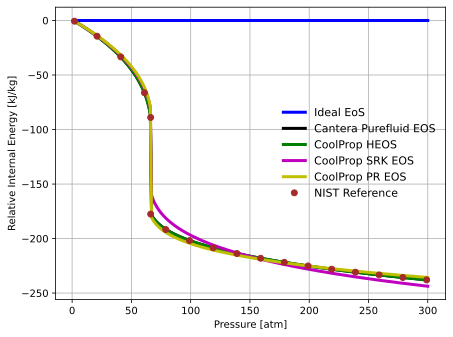

In [81]:
ax = plot_p(p_1, "Relative Internal Energy [kJ/kg]", u_ideal_CO2_GRI, u_Pure_CO2, u_CoolProp_HEOS_CO2, u_CoolProp_SRK_CO2, u_CoolProp_PR_CO2, 
     labels=["Ideal EoS", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Adjusted Internal Energy'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=[1, 20, 40, 60, 66, 67, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]) #Includes values near phase transition, 66.253atm
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/CO2/u-P Graph of CO2.svg")
plt.show()

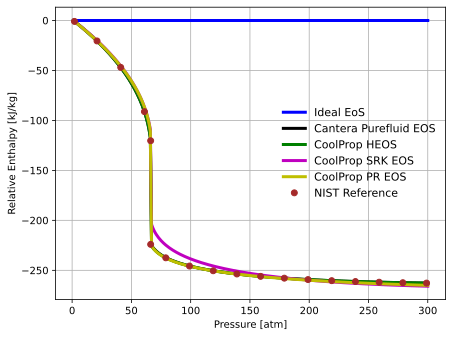

In [82]:
ax = plot_p(p_1, "Relative Enthalpy [kJ/kg]", h_ideal_CO2_GRI, h_Pure_CO2, h_CoolProp_HEOS_CO2, h_CoolProp_SRK_CO2, h_CoolProp_PR_CO2, 
     labels=["Ideal EoS", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Adjusted Enthalpy'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=[1, 20, 40, 60, 66, 67, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/CO2/h-P Graph of CO2.svg")
plt.show()

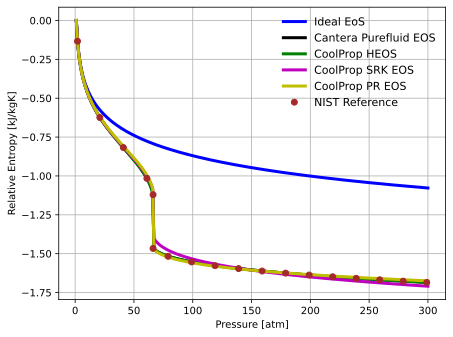

In [83]:
ax = plot_p(p_1, "Relative Entropy [kJ/kgK]", s_ideal_CO2_GRI, s_Pure_CO2, s_CoolProp_HEOS_CO2, s_CoolProp_SRK_CO2, s_CoolProp_PR_CO2, 
     labels=["Ideal EoS", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Adjusted Entropy'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=[1, 20, 40, 60, 66, 67, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/CO2/s-P Graph of CO2.svg")
plt.show()

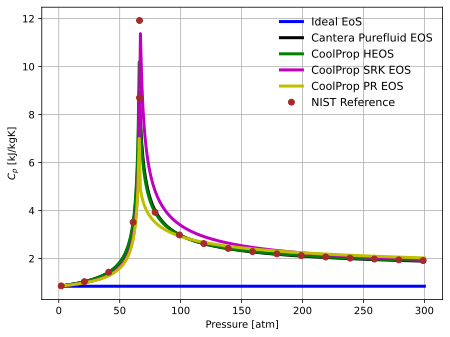

In [84]:
ax = plot_p(p_1, "$C_p$ [kJ/kgK]", cp_ideal_CO2_GRI, cp_Pure_CO2, cp_CoolProp_HEOS_CO2, cp_CoolProp_SRK_CO2, cp_CoolProp_PR_CO2, 
     labels=["Ideal EoS", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Cp (J/g*K)'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=[1, 20, 40, 60, 66, 67, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/CO2/cp-P Graph of CO2.svg")
plt.show()

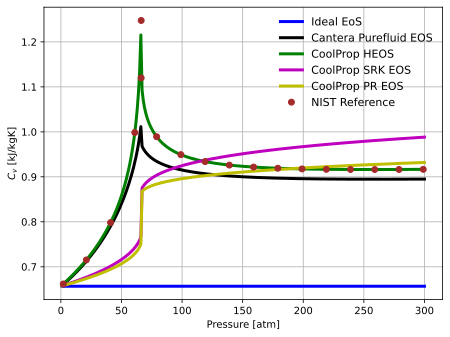

In [85]:
ax = plot_p(p_1, "$C_v$ [kJ/kgK]", cv_ideal_CO2_GRI, cv_Pure_CO2, cv_CoolProp_HEOS_CO2, cv_CoolProp_SRK_CO2, cv_CoolProp_PR_CO2, 
     labels=["Ideal EoS", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Cv (J/g*K)'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=[1, 20, 40, 60, 66, 67, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/CO2/cv-P Graph of CO2.svg")
plt.show()

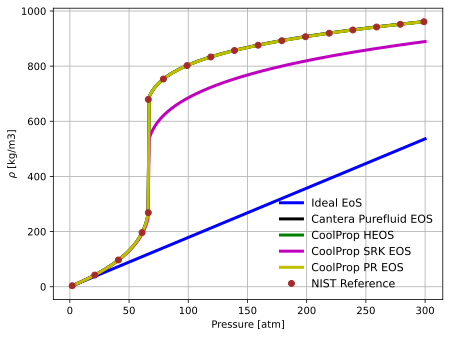

In [86]:
ax = plot_p(p_1, r"$\rho$ [kg/m3]", rho_ideal_CO2_GRI, rho_Pure_CO2, rho_CoolProp_HEOS_CO2, rho_CoolProp_SRK_CO2, rho_CoolProp_PR_CO2, 
     labels=["Ideal EoS", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Density (kg/m3)'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=[1, 20, 40, 60, 66, 67, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/CO2/rho-P Graph of CO2.svg")
plt.show()

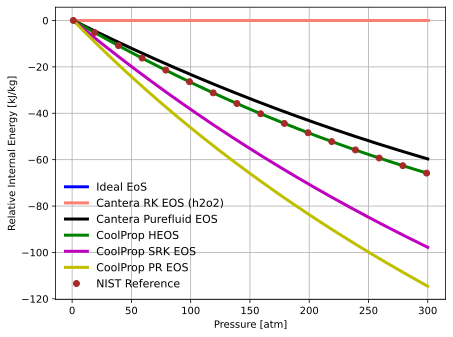

In [88]:
ax = plot_p(p_1, "Relative Internal Energy [kJ/kg]", u_ideal_H2_GRI, u_RK_H2, u_Pure_H2, u_CoolProp_HEOS_H2, u_CoolProp_SRK_H2, u_CoolProp_PR_H2,
     labels=["Ideal EoS ", "Cantera RK EOS (h2o2)", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "salmon", "k", "g", "m", "y"])
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Adjusted Internal Energy'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=20)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/H2/u-P Graph of H2.svg")
plt.show()

Since the RK_EOS seems identical to the Ideal Gas EOS it won't be plotted moving further

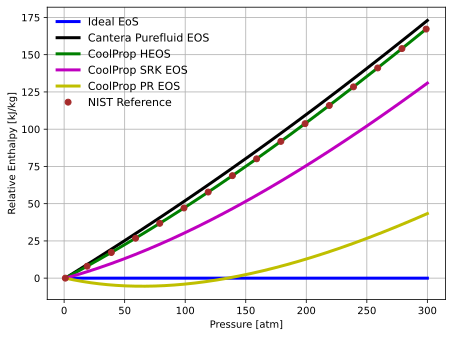

In [89]:
ax = plot_p(p_1, "Relative Enthalpy [kJ/kg]", h_ideal_H2_GRI, h_Pure_H2, h_CoolProp_HEOS_H2, h_CoolProp_SRK_H2, h_CoolProp_PR_H2,
     labels=["Ideal EoS ", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Adjusted Enthalpy'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=20)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/H2/h-P Graph of H2.svg")
plt.show()

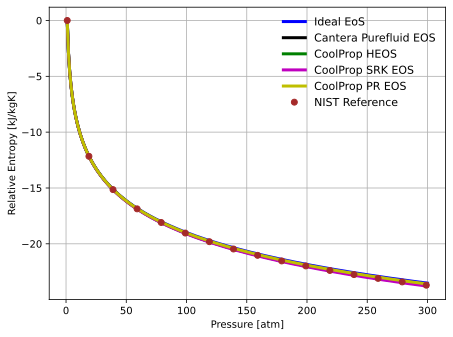

In [90]:
ax = plot_p(p_1, "Relative Entropy [kJ/kgK]", s_ideal_H2_GRI, s_Pure_H2, s_CoolProp_HEOS_H2, s_CoolProp_SRK_H2, s_CoolProp_PR_H2,
     labels=["Ideal EoS ", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Adjusted Entropy'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=20)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/H2/s-P Graph of H2.svg")
plt.show()

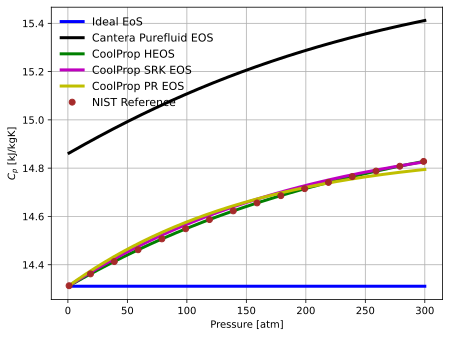

In [91]:
ax = plot_p(p_1, "$C_p$ [kJ/kgK]", cp_ideal_H2_GRI, cp_Pure_H2, cp_CoolProp_HEOS_H2, cp_CoolProp_SRK_H2, cp_CoolProp_PR_H2,
     labels=["Ideal EoS ", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Cp (J/g*K)'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=20)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/H2/cp-P Graph of H2.svg")
plt.show()

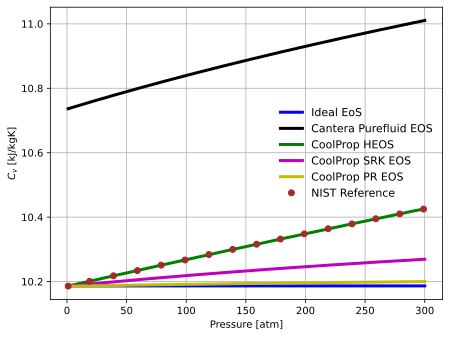

In [92]:
ax = plot_p(p_1, "$C_v$ [kJ/kgK]", cv_ideal_H2_GRI, cv_Pure_H2, cv_CoolProp_HEOS_H2, cv_CoolProp_SRK_H2, cv_CoolProp_PR_H2,
     labels=["Ideal EoS ", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Cv (J/g*K)'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=20)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/H2/cv-P Graph of H2.svg")
plt.show()

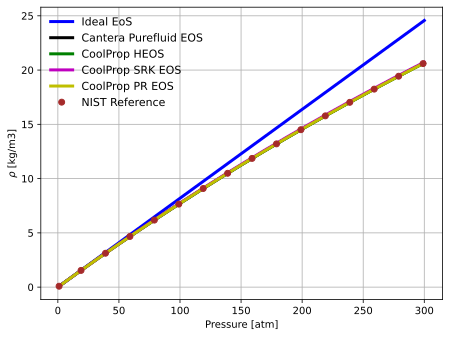

In [93]:
ax = plot_p(p_1, r"$\rho$ [kg/m3]", rho_ideal_H2_GRI, rho_Pure_H2, rho_CoolProp_HEOS_H2, rho_CoolProp_SRK_H2, rho_CoolProp_PR_H2,
     labels=["Ideal EoS ", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "g", "m", "y"])
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Density (kg/m3)'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=20)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/H2/rho-P Graph of H2.svg")
plt.show()

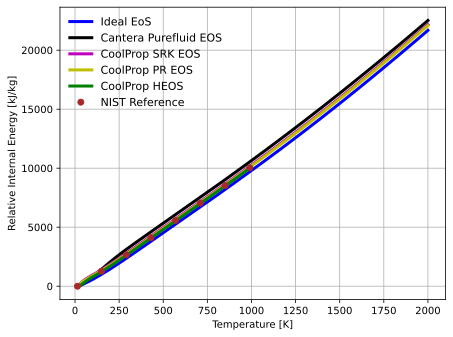

In [95]:
ax = plot_T(T_2, "Relative Internal Energy [kJ/kg]", u_ideal_H2_GRI_Tvar, u_Pure_H2_Tvar, u_CoolProp_SRK_H2_Tvar, u_CoolProp_PR_H2_Tvar,
     labels=["Ideal EoS ", "Cantera Purefluid EOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "k", "m", "y"])
ax.plot(T_2_H2_CP, u_CoolProp_HEOS_H2_Tvar, "-", lw=3, label="CoolProp HEOS", color="g")
ax.plot(H2_ref_T['Temperature (K)'], H2_ref_T['Adjusted Internal Energy'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=14)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/H2/u-T Graph of H2.svg")
plt.show()

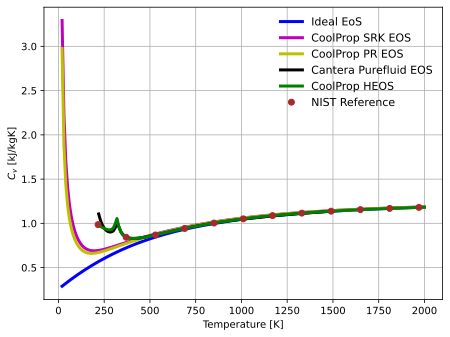

In [97]:
ax = plot_T(T_2, "$C_v$ [kJ/kgK]", cv_ideal_CO2_GRI_Tvar, cv_CoolProp_SRK_CO2_Tvar, cv_CoolProp_PR_CO2_Tvar, 
     labels=["Ideal EoS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "m", "y"])
ax.plot(T_2_CO2, cv_Pure_CO2_Tvar, "-", lw=3, label="Cantera Purefluid EOS", color="k")
ax.plot(T_2_CO2_CP, cv_CoolProp_HEOS_CO2_Tvar, "-", lw=3, label="CoolProp HEOS", color="g")
ax.plot(CO2_ref_T['Temperature (K)'], CO2_ref_T['Cv (J/g*K)'], " ", label="NIST Reference", color="brown", marker="o", 
        markevery=16)
ax.legend(prop={"size": 11}, frameon=False)
plt.savefig("Graphs/Single Species/CO2/cv-T Graph of CO2.svg")
plt.show()

## Bonus: Temperature-Density plots with Pressure Isobars

The following is modified from the Non Ideal EOS Cantera Example. It plots the $T$-$\rho$ diagram of CO2 over a wide pressure
and temperature range. \
The temperature is varied from 250 K to 400 K. The pressure is
changed from 1 bar to 600 bar.

Getting reference data for this requires 10 sets of data (10 Isobars) from the NIST web database
Should we do this for all 6 properties of all 6 species (Totaling 360 Isobars)? Doesn't seem feasible without automation

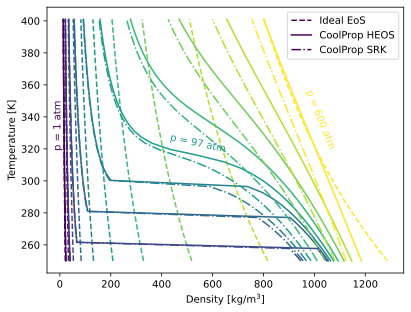

In [153]:
# Input parameters
# Set up arrays for pressure and temperature
p_array = np.logspace(1, np.log10(600), 10, endpoint=True)
T_array = np.linspace(250, 401, 40)  # Temperature is varied from 250K to 400K
p_array = 101325 * np.array(p_array)[:, np.newaxis]

# Calculate densities for GRI Ideal Gas  phase
states = ct.SolutionArray(ideal_gas1, shape=(p_array.size, T_array.size))
states.TPX = T_array, p_array, "CO2:1.0"
density_ideal = states.density


p_HEOS, T_HEOS = np.meshgrid(p_array, T_array)
density_coolprop_HEOS = PropsSI("D", "P", np.ravel(p_HEOS), "T", np.ravel(T_HEOS), "HEOS::CO2")
density_coolprop_HEOS = density_coolprop_HEOS.reshape(p_HEOS.shape)

p_SRK, T_SRK = np.meshgrid(p_array, T_array)
density_coolprop_SRK = PropsSI("D", "P", np.ravel(p_SRK), "T", np.ravel(T_SRK), "SRK::CO2")
density_coolprop_SRK = density_coolprop_SRK.reshape(p_SRK.shape)

# Plot
import cycler
color = plt.cm.viridis(np.linspace(0, 1, p_array.size))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, ax = plt.subplots()
ideal_line = ax.plot(density_ideal.T, T_array, "--", label="Ideal EoS")
CP_line = ax.plot(density_coolprop_HEOS, T_array, "-", label="CoolProp HEOS")
CP2_line = ax.plot(density_coolprop_SRK, T_array, "-.", label="CoolProp SRK")
ax.text(-27.5, 320, "p = 1 atm", color=color[0], rotation="vertical")
ax.text(430, 318, "p = 97 atm", color=color[5], rotation=-12)
ax.text(960, 320, "p = 600 atm", color=color[9], rotation=-68)
ax.set_xlabel("Density [kg/m$^3$]")
ax.set_ylabel("Temperature [K]")
ax.legend(handles=[ideal_line[0], CP_line[0], CP2_line[0]])
plt.savefig("BonusExample_rhoCO2_along_Isobars.svg")

The figure compares $T-\rho$ plots for ideal, R-K, and Helmholtz EoS at
different operating pressures. All three EoS yield the same plots at low pressures (0
bar and 10 bar), but depart at higher pressures. 

CoolProps SRK EOS tends to a different grouped density than the HEOS, and as such underpredicts Densities.

The ideal gas EOS differs significantly at pressures slightly higher than 10 bar. Interestingly, it begins approaches, then overtakes CoolProps HEOS at very high pressures (600 bar). This means there is a certain pressure, where the ideal gas EOS would match with CoolProps EOS quite closely.

.. [1] I.H. Bell, J. Wronski, S. Quoilin, V. Lemort, "Pure and Pseudo-pure Fluid
   Thermophysical Property Evaluation and the Open-Source Thermophysical Property
   Library CoolProp," Industrial & Engineering Chemistry Research 53 (2014),
   https://pubs.acs.org/doi/10.1021/ie4033999

.. [2] R. Span, "Multiparameter Equations of State - An Accurate Source of
   Thermodynamic Property Data," Springer Berlin Heidelberg (2000),
   https://dx.doi.org/10.1007/978-3-662-04092-8

.. [3] A. Saeed, S. Ghader, "Calculation of density, vapor pressure and heat capacity
   near the critical point by incorporating cubic SRK EoS and crossover translation,"
   Fluid Phase Equilibria (2019) 493, https://doi.org/10.1016/j.fluid.2019.03.027

